Práctica Final NLP José Carlos Amo Pérez
## 3. Etapa de entrenamiento y testeo de un modelo de análisis de sentimiento

Citation:

<small>Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016
https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf</small>

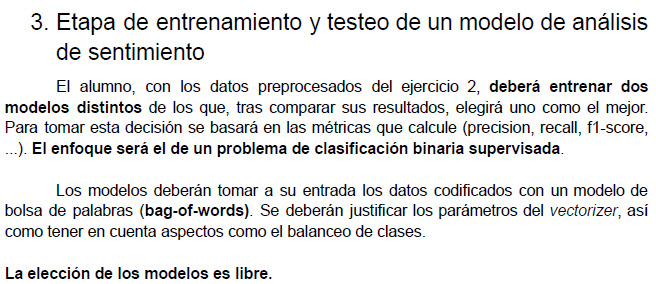

In [1]:
# Carga e importación de librerias:
!python -m spacy download en_core_web_sm
!pip install stop_words
!pip install num2words
!pip install contractions

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
import spacy
import unicodedata
from num2words import num2words
from stop_words import get_stop_words
import string
import re
import pandas as pd
import numpy as np
import gzip
import en_core_web_sm
from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk.probability import FreqDist
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import io
import decimal
from decimal import Decimal, InvalidOperation
import contractions
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
import random
from nltk.corpus import wordnet as wn
from sklearn.model_selection import GridSearchCV



2023-03-12 19:54:11.073078: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 19:54:12.217791: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 19:54:12.217915: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-12 19:54:12.217951: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Cargo el conjunto de datos que estoy manejando tras la etapa de Exploración
# Este df se diferencia del original en que los nombres de las columnas se han traducido y
# en que se han añadido dos nuevas columnas "Palabras#" y "Frases#"
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv('/content/gdrive/My Drive/NLP/df_procesado.csv')

Mounted at /content/gdrive


In [3]:
print(df.shape)


(2478, 2)


In [4]:
df.head(3)

,Calificación,Comentario
0,0,b005mr6ihk a3vg7f7szuk87s like tuner look size...
1,1,b004z17008 a12o5b8xnknbol work great easy use ...
2,0,b0002e1g5c a1cf9if5fwynu0 wire clipper winder ...


Divido los datos en train y test:

In [5]:
# Uso la función train_test_split() de sklearn para dividir los datos en dos subconjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['Comentario'],
    df['Calificación'],
    train_size=0.75,         #El 75% de los datos van a train
    test_size=0.25,          #El 25% restante a test
    random_state=42,         #Semilla para el generador de números aleatorios par que la división de los datos sea reproducible.
    shuffle=True
)

Voy a vectorizar el df

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = TfidfVectorizer(       #Creo una instancia de TfidfVectorizer
    max_df=0.95,            # frecuencia máxima de documento = 0.95 (excluye palabras que aparecen en más del 95% de las filas)
    min_df=3,               # frecuencia mínima de documento = 3 (excluye palabras que aparecen en menos de 3 filas)
    max_features=2500,      # número máximo de características que se crearán = 2500
    ngram_range=(1, 1)      # genero características para n-gramas de longitud 1, 2 y 3
)
cv.fit(X_train)    #ajusto el vectorizador a los datos de entrenamiento X_train 

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3)

En este momento dispongo de un vocabulario de palabras únicas y sus respectivas representaciones vectoriales numéricas utilizando el esquema TF-IDF

A continuación voy a obtener los conjuntos de datos X_train_ y X_test_ que representan los 'Comentarios' transformados en una matriz de características con un número finito de filas y columnas. Las filas representan cada Comentario y cada columna representa una palabra o término considerado relevante según los parámetros utilizados en el vectorizador.

In [7]:
# Obtengo los conjuntos de datos X_train y X_test 
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

<font color="darkblue">**MODELO 1: MODELO DE REGRESIÓN LOGÍSTICA**</font>

Paso a hacer el entrenamiento usando grid search

In [8]:
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import numpy as np
# Define los valores que se probarán para el parámetro de regularizacion o hiperparámetro C
param_grid = {'C': [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]}

# Creo un objeto GridSearchCV y ajusta el modelo de regresión logística usando los datos de entrenamiento
lr = LogisticRegression(solver='liblinear', penalty='l2', max_iter=250)   #Ridge
lr.fit(X_train_, y_train)
grid_search = GridSearchCV(lr, param_grid, cv=5)
grid_search.fit(X_train_, y_train)

# Imprimo los mejores valores de los hiperparámetros
print("Mejor valor de C:", grid_search.best_params_)

# Utilizo el modelo ajustado para hacer predicciones sobre los datos de entrenamiento y prueba
train_predict = grid_search.predict(X_train_)
test_predict = grid_search.predict(X_test_)

# Calculo y almaceno la precisión de la predicción en los conjuntos de entrenamiento y prueba
train_acc = accuracy_score(y_train, train_predict)
test_acc = accuracy_score(y_test, test_predict)

# Genero una curva de aprendizaje para el modelo con los mejores hiperparámetros encontrados
train_sizes, train_scores, valid_scores = learning_curve(grid_search.best_estimator_, X_train_, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Imprimo los tamaños de los conjuntos de entrenamiento y las precisiones obtenidas
print('\nTamaños de conjunto de entrenamiento:', train_sizes)
print('\nPrecisiones en el conjunto de entrenamiento:', np.mean(train_scores, axis=1))
print('\nPrecisiones en el conjunto de validación:', np.mean(valid_scores, axis=1))


Mejor valor de C: {'C': 1}

Tamaños de conjunto de entrenamiento: [ 148  297  445  594  743  891 1040 1188 1337 1486]

Precisiones en el conjunto de entrenamiento: [0.96621622 0.94074074 0.96359551 0.95252525 0.94185734 0.92255892
 0.92153846 0.91784512 0.90860135 0.90323015]

Precisiones en el conjunto de validación: [0.58447816 0.58338405 0.64206156 0.66091065 0.69212242 0.70666899
 0.71043243 0.72010985 0.72656581 0.72548039]


Despues de probar con varias combinaciones una de las que mejor resultado me da es esta: solver='liblinear', penalty='l2', max_iter=250. en todo caso no es un buen resultado porque muestra un claro overfiting

Voy a mirar Accuracy en ambos conjuntos de datos

In [9]:
print(f'Accuracy sobre los datos de entrenamiento = {train_acc}')
print(f'Accuracy sobre los datos de test = {test_acc}')

Accuracy sobre los datos de entrenamiento = 0.8923573735199138
Accuracy sobre los datos de test = 0.7129032258064516


Hay overfiting en el modelo ya que el acc en los datos de test, aun siendo alto, es menor que el acc en los datos de entrenamiento

Voy a ver cómo quedan las predicciones

In [10]:
def predict_review_sentiment(review_index, model):
    print('Calificación actual: {}'.format(df.iloc[review_index]['Calificación']))
    r = df.iloc[review_index]['Comentario']
    print('Calificación predicha: {}'.format(lr.predict(cv.transform([r]))))


for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 1797
Calificación actual: 0
Calificación predicha: [0]

Review no. 1573
Calificación actual: 0
Calificación predicha: [0]

Review no. 2395
Calificación actual: 1
Calificación predicha: [1]

Review no. 2416
Calificación actual: 0
Calificación predicha: [0]

Review no. 1204
Calificación actual: 1
Calificación predicha: [1]

Review no. 2352
Calificación actual: 1
Calificación predicha: [1]

Review no. 1942
Calificación actual: 1
Calificación predicha: [0]

Review no. 954
Calificación actual: 1
Calificación predicha: [1]

Review no. 1173
Calificación actual: 0
Calificación predicha: [1]

Review no. 363
Calificación actual: 0
Calificación predicha: [0]


El 80% de las que he pedido mostrar están bien

Pensando en la cuarta pregunta del examen voy a almacenar la matriz de confusión en un archivo csv llamado "Matriz_Confusion_Modelo1" que contendrá dichos valores de la matriz de confusion y que podré usar en esa próxima pregunta 4.

También voy a almacenar el reporte de clasificación en un archivo csv llamado "Classification_Report_Modelo1" que contendrá dichos valores del classification_report, para ser usados en la pregunta 4.

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Predigo los valores para el conjunto de prueba
y_pred = grid_search.predict(X_test_)

# Calculo la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Creo una funcion para calcular y guardar las métricas
def Reporte_de_Metricas (cm, ruta_metricas, ruta_cr): 
  TN = cm[0][0]
  FP = cm[0][1]
  FN = cm[1][0]
  TP = cm[1][1]
  Accuracy = (TP+TN)/(TP+FP+FN+TN)
  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)
  Especificity = TN/(TN+FP)
  #“Accuracy” (Exactitud): proporcion de predicciones correctas Accuracy = (VP+VN)/(VP+FP+FN+VN)
  #“Precision”: proporcion de "1" detectados Precision = VP/(VP+FP)
  #“Recall” o “Sensitivity”: proporción de casos "1" correctamente detectados Recall = VP/(VP+FN)
  #“Especificity”: proporción de casos "0" correctamente detectados Especificity = VN/(VN+FP)
  indicador = ['TN', 'FP', 'FN', 'TP', 'Accuracy', 'Precision', 'Recall', 'Especificity']
  valor = [TN, FP, FN, TP, Accuracy, Precision, Recall, Especificity]
  metricas = pd.DataFrame({'Indicador': indicador, 'Valor': valor})
  # Guardo el dataframe en drive
  drive.mount('/content/drive')
  rutam = ruta_metricas
  metricas.to_csv(rutam, index=False)
  
  # Calcula el reporte de clasificación
  #cr = classification_report(y_test, y_pred)
  cr_dict = classification_report(y_test, y_pred, output_dict=True)
  # Creo un df con el informe de clasificacion
  informe_clasificacion = pd.DataFrame(cr_dict).transpose()
  informe_clasificacion.reset_index(inplace=True)
  # Guardo el dataframe en drive
  drive.mount('/content/drive')
  rutacr = ruta_cr
  informe_clasificacion.to_csv(rutacr, index=False)
  return

#Ejecuto esa función
ruta_metricas = '/content/drive/My Drive/NLP/Metricas_modelo1_lr.csv'
ruta_cr = '/content/drive/My Drive/NLP/CR_Modelo1_lr.csv'

Reporte_de_Metricas (cm, ruta_metricas, ruta_cr)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


El modelo tiene un rendimiento similar para ambas clases, con un ligero mejor rendimiento en términos de precisión para la clase 1 y en términos de sensibilidad para la clase 0. El valor de F1-score es similar para ambas clases, lo que indica un equilibrio razonable entre precisión y recall.

<font color="darkblue">**MODELO 2: MODELO K-NEAREST NEIGHBORS (KNN)**</font>

In [17]:
# Mantengo la división entre train y test y el vectorizador de datos

from sklearn.neighbors import KNeighborsClassifier # Reporte
# Define los valores que se probarán para el parámetro de regularizacion o hiperparámetro C
param_grid_2 = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}

# Creo un nuevo objeto GridSearchCV y ajusta el modelo KNN usando los datos de entrenamiento
knn = KNeighborsClassifier(weights='uniform', algorithm='auto', metric='euclidean', p=2)
knn.fit(X_train_, y_train)
grid_search_2 = GridSearchCV(knn, param_grid_2, cv=5)
grid_search_2.fit(X_train_, y_train)

# Imprimo los mejores valores de los hiperparámetros
print("Mejor valor de n_neighbors:", grid_search_2.best_params_)

# Utilizo el modelo ajustado para hacer predicciones sobre los datos de entrenamiento y prueba
train_predict_2 = knn.predict(X_train_)
test_predict_2 = knn.predict(X_test_)

# Calculo y almaceno la precisión de la predicción en los conjuntos de entrenamiento y prueba
train_acc_2 = accuracy_score(y_train, train_predict_2)
test_acc_2 = accuracy_score(y_test, test_predict_2)

# Genero una curva de aprendizaje para el modelo con los mejores hiperparámetros encontrados
train_sizes, train_scores, valid_scores = learning_curve(knn, X_train_, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Imprimo los tamaños de los conjuntos de entrenamiento y las precisiones obtenidas
print('\nTamaños de conjunto de entrenamiento:', train_sizes)
print('\nPrecisiones en el conjunto de entrenamiento:', np.mean(train_scores, axis=1))
print('\nPrecisiones en el conjunto de validación:', np.mean(valid_scores, axis=1))



print(f'\Accuracy sobre los datos de entrenamiento = {train_acc_2}')
print(f'Accuracy sobre los datos de test = {test_acc_2}')

def predict_review_sentiment(review_index, model):
    print('Calificación actual: {}'.format(df.iloc[review_index]['Calificación']))
    r = df.iloc[review_index]['Comentario']
    print('Calificación predicha: {}'.format(knn.predict(cv.transform([r]))))

for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)

Mejor valor de n_neighbors: {'n_neighbors': 11}

Tamaños de conjunto de entrenamiento: [ 148  297  445  594  743  891 1040 1188 1337 1486]

Precisiones en el conjunto de entrenamiento: [0.78378378 0.78720539 0.76089888 0.75454545 0.76312248 0.7674523
 0.76288462 0.76262626 0.75557218 0.75437416]

Precisiones en el conjunto de validación: [0.57156189 0.56459148 0.58989653 0.59203837 0.60550822 0.60121294
 0.59473959 0.59258325 0.58720111 0.59205142]
\Accuracy sobre los datos de entrenamiento = 0.7648008611410119
Accuracy sobre los datos de test = 0.5983870967741935

Review no. 347
Calificación actual: 1
Calificación predicha: [1]

Review no. 133
Calificación actual: 1
Calificación predicha: [1]

Review no. 2458
Calificación actual: 0
Calificación predicha: [0]

Review no. 1264
Calificación actual: 0
Calificación predicha: [1]

Review no. 394
Calificación actual: 1
Calificación predicha: [1]

Review no. 954
Calificación actual: 1
Calificación predicha: [1]

Review no. 2329
Calificación a

Accuracy sobre los datos de entrenamiento = 0.7648008611410119
Accuracy sobre los datos de test = 0.5983870967741935

Esto indica claramente overfiting. Igual que en el modelo 1 el resultado que presento es el obtenido tras ajustar los valores de weights='uniform', algorithm='auto', metric='euclidean', p=2.

In [19]:
# Predice los valores para el conjunto de prueba
y_pred2 = grid_search_2.predict(X_test_)

# Calcula la matriz de confusión
cm_2 = confusion_matrix(y_test, y_pred2)

# Imprime la matriz de confusion
print(cm_2)

#Ejecuto la función para guardar en drive las métricas y el informe de clasificación
ruta_metricas = '/content/drive/My Drive/NLP/Metricas_modelo2_KNN.csv'
ruta_cr = '/content/drive/My Drive/NLP/CR_Modelo2_KNN.csv'

Reporte_de_Metricas (cm_2, ruta_metricas, ruta_cr)

[[178 124]
 [120 198]]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color="darkblue">**MODELO 3: MODELO NAIVE BAYES. (el ejercicio no lo pide, pero siento intriga)**</font>

In [20]:
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV  

param_grid_3 = {'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]}  

# Creo un objeto GridSearchCV y ajusta el modelo de Naive Bayes usando los datos de entrenamiento  
nb = MultinomialNB()  
grid_search_3 = GridSearchCV(nb, param_grid_3, cv=5)  
grid_search_3.fit(X_train_, y_train)

# Imprimo los mejores valores de los hiperparámetros
print("Mejor valor de alpha:", grid_search_3.best_params_['alpha'])  

# Utilizo el modelo ajustado para hacer predicciones sobre los datos de entrenamiento y prueba
train_predict_3 = grid_search_3.predict(X_train_)
test_predict_3 = grid_search_3.predict(X_test_)

# Calculo y almaceno la precisión de la predicción en los conjuntos de entrenamiento y prueba
train_acc_3 = accuracy_score(y_train, train_predict_3)
test_acc_3 = accuracy_score(y_test, test_predict_3)

# Voy a mirar Accuracy en ambos conjuntos de datos
print(f'Accuracy sobre los datos de entrenamiento = {train_acc_3}')
print(f'Accuracy sobre los datos de test = {test_acc_3}')

def predict_review_sentiment(review_index, model):
    print('Calificación actual: {}'.format(df.iloc[review_index]['Calificación']))
    r = df.iloc[review_index]['Comentario']
    print('Calificación predicha: {}'.format(grid_search.predict(cv.transform([r]))))

for i in random.sample(range(0, len(df)), 10):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, nb)  # Cambio 

Mejor valor de alpha: 0.7
Accuracy sobre los datos de entrenamiento = 0.9058127018299247
Accuracy sobre los datos de test = 0.7080645161290322

Review no. 314
Calificación actual: 0
Calificación predicha: [0]

Review no. 2391
Calificación actual: 0
Calificación predicha: [1]

Review no. 1022
Calificación actual: 1
Calificación predicha: [1]

Review no. 935
Calificación actual: 0
Calificación predicha: [0]

Review no. 401
Calificación actual: 0
Calificación predicha: [0]

Review no. 1468
Calificación actual: 1
Calificación predicha: [0]

Review no. 1672
Calificación actual: 1
Calificación predicha: [1]

Review no. 1084
Calificación actual: 1
Calificación predicha: [1]

Review no. 997
Calificación actual: 0
Calificación predicha: [0]

Review no. 2299
Calificación actual: 0
Calificación predicha: [1]


Pues este tercer modelo también presenta mucho overfiting.

Voy a guardar resultados para el punto 4 de la práctica que viene a continuación

In [22]:
# Predice los valores para el conjunto de prueba
y_pred3 = grid_search_3.predict(X_test_)

# Calcula la matriz de confusión
cm_3 = confusion_matrix(y_test, y_pred3)

# Imprime la matriz de confusion
print(cm_3)

#Ejecuto la función para guardar en drive las métricas y el informe de clasificación
ruta_metricas = '/content/drive/My Drive/NLP/Metricas_modelo3_NaiveB.csv'
ruta_cr = '/content/drive/My Drive/NLP/CR_Modelo3_NaiveB.csv'

Reporte_de_Metricas (cm_3, ruta_metricas, ruta_cr)

[[221  81]
 [100 218]]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
